# Spiking Phasor VSA: Spatial Memory

## Prelims

In [1]:
from numpy import *
from matplotlib.pyplot import *
from tqdm import tqdm
from phasorutils import *
from brian2 import *
from spikingVSA import *
from copy import deepcopy

In [2]:
import lib.python.lib_FHRR_Loihi as lib
import lib.python.utility as util
import lib.python.reuse_model as app
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps

# Set up a VSA and spatial memory

## Some classes to help us
These classes are just used to set up the demonstrations, and aren't directly part of the spiking-phasor implementation.

In [3]:
class thing():
    '''
     thing(v, label) represents a labelled vector.
    '''
    def __init__(self, v, label):
        self.v = v
        self.label = label

class xyaxis():
    '''
     xyaxis(S) simply stores a vector for each axis.
     S holds the axis vectors in its rows.
    '''
    def __init__(self, S):
        self.vec = S
    def __getitem__(self, idx):
        return self.vec[idx]
        
class vocab():
    '''
     V = vocab(dim) creates a VSA vocabulary with
     vectors of dimension dim.
    '''
    def __init__(self, dim):
        self.dim = dim
        self.stuff = []
        
    def list_labels(self):
        '''V.list_labels() lists all the labels in the vocab.'''
        for k,obj in enumerate(self.stuff):
            print(f'{k}: {self[k].label}')
            
    def all_labels(self):
        '''V.all_labels() returns an array'''
        alll = []
        for obj in self.stuff:
            alll.append(obj.label)
        return array(alll)
    
    def all_vectors(self):
        '''
        V.all_vectors() returns an array containing all the vectors
        in the vocab, one per row.
        '''
        allv = []
        for obj in self.stuff:
            allv.append(obj.v)
        return array(allv)
            
    def add(self, v, label):
        '''V.add(v, label) adds the vector v to the vocab, with a string label.'''
        self.stuff.append(thing(v, label))
        
    def add_combinations(self, idxs1, idxs2):
        '''
        Adds all combinations of things from index list idxs1 with
        things from index list idxs2.
        '''
        for k1 in idxs1:
            for k2 in idxs2:
                self.add(self[k1].v * self[k2].v, f'{self[k1].label} {self[k2].label}')
        
    def __getitem__(self, idx):
        return self.stuff[idx]

## Create a VSA vocabulary

In [4]:
# Create hypervectors...

# ... for spatial axes...
ssp = HexSSP(thetas=arange(0, 120, 15), scales=linspace(0.1, pi, 20))

# ... and for symbols.
M = 10
N = ssp.dimension()
ds = SparsePhaseMap(M=M, N=N, sparsity=1.)

Number of phasors: 2


In [5]:
N

480

In [6]:
# Create the vocab,
V = vocab(N)

# and add the vectors.
V.add(ds.S[0], 'red')
V.add(ds.S[1], 'blue')
V.add(ds.S[2], 'green')
V.add(ds.S[3], 'square')
V.add(ds.S[4], 'circle')
V.add(ds.S[5], 'triangle')

V.add_combinations([0,1,2], [3,4,5])

# Also create an axis object
X = xyaxis(ssp.S)
xscale = 0.5
yscale = 0.5

In [7]:
V.list_labels()

0: red
1: blue
2: green
3: square
4: circle
5: triangle
6: red square
7: red circle
8: red triangle
9: blue square
10: blue circle
11: blue triangle
12: green square
13: green circle
14: green triangle


In [8]:

def similarity(v, all_vectors):
    """
    Compute the similarity between a vector and all vectors in a set.
    
    Parameters:
    v (array): The query vector
    all_vectors (array): A 2D array where each row is a vector to compare against
    
    Returns:
    tuple: (index of most similar vector, array of similarity scores)
    """
    # Compute dot product between v and all vectors
    dot_products = np.dot(all_vectors, v)
    
    # Find the index of the maximum similarity
    max_idx = np.argmax(dot_products)
    
    # Normalize dot products to get cosine similarity
    similarities = dot_products / (np.linalg.norm(all_vectors, axis=1) * np.linalg.norm(v))
    
    return max_idx, similarities


In [9]:
# This is how we get the similarity of one vector to all the others
# in the vocabulary.
idx, sims = similarity(V[1].v, V.all_vectors())
print(f'Best match is at index {idx}')
print(sims)

Best match is at index 3
[-0.01932774+0.01154824j -0.01918487+0.02200624j -0.03751286-0.0587341j
  0.03865434-0.03934823j  0.01019125-0.04099577j -0.02745683+0.01830604j
  0.00445801-0.01205729j  0.01945935+0.00564096j -0.04817722-0.0089936j
  0.00229674-0.05667443j  0.02025808-0.01915034j -0.07783687-0.03952849j
 -0.0427209 -0.06612201j  0.02532024-0.01532459j  0.00808776-0.04701694j]


## Create a spatial memory

In [10]:
# Red Square at (-1.3, -1.1)
rsx = [-1.3, -1.1]
rs = V[6].v * X[0]**(rsx[0]/xscale) * X[1]**(rsx[1]/yscale)

In [11]:
# Blue Circle at (1.2, 0.5)
bcx = [1.2, 0.5]
bc = V[10].v * X[0]**(bcx[0]/xscale) * X[1]**(bcx[1]/yscale)

In [12]:
# Green Triangle at (-1.4, 1.7)
gtx = [-1.4, 1.7]
gt = V[14].v * X[0]**(gtx[0]/xscale) * X[1]**(gtx[1]/yscale)

In [13]:
# Create the bundle of all 3 objects
F = rs + bc + gt
F /= abs(F)    # normalize it

In [14]:
def draw_shapes():
    lw = 5
    circle = plt.Circle(bcx, 0.25, fc='none', ec='blue', lw=lw)
    plt.gca().add_patch(circle); plot(bcx[0], bcx[1], 'b+')
    square = plt.Rectangle(array(rsx)-array([0.25,0.25]), 0.5, 0.5, fc='none', ec='red', lw=lw)
    plt.gca().add_patch(square); plot(rsx[0], rsx[1], 'r+')
    pts = array([[-0.25, -0.18],[0.25, -0.18],[0,0.27]])
    triangle = Polygon(gtx+pts, fc='none', ec='green', lw=lw)
    plt.gca().add_patch(triangle); plot(gtx[0], gtx[1], 'g+')

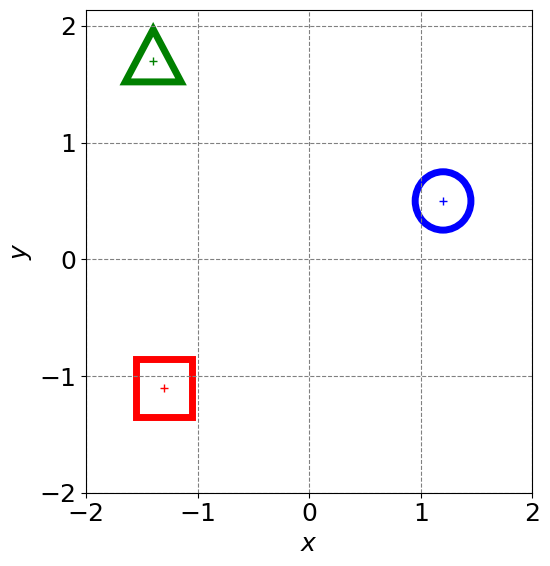

In [15]:
font = {'size': 18}
matplotlib.rc('font', **font)
radius = 2

figure(figsize=(3*radius, 3*radius))
grid('on', ls='--', color='gray'); xlabel(r'$x$'); ylabel(r'$y$');
draw_shapes(); tight_layout();
xticks(arange(-radius, radius+1.e-5, 1))
yticks(arange(-radius, radius+1.e-5, 1))
savefig('object_locations.pdf')

# Spiking Phasors

### Net-1: location query

In [16]:
# Net-1
# Create the spiking-phasor network
net = SpikingPhasorNet()
freq = 10.

# Spiking phasor population that outputs the spatial memory
Fpop = GenerateSP(N=N, C=F, freq=freq); net.add_pop(Fpop)

x = rsx  # location to query

# Query vector: "What is at location..."
q = X[0]**(x[0]/xscale) * X[1]**(x[1]/yscale)


In [17]:

# CSpiking phasor population that outputs the query vector
Q1 = GenerateSP(N=N, C=q, freq=freq); net.add_pop(Q1)

# Phase difference population (computes unbinding)
Z1 = PhaseDiffPop(N=N, freq=freq); net.add_pop(Z1)
net.deconvolve(Fpop, Q1, Z1)

# The relay population goes silent after 1 second.
relay3 = SpikingPhasorPop(N=N, freq=freq, stop_at=1.); net.add_pop(relay3)
net.connect(Z1, relay3, W=eye(N))

# Cleanup memory gets initialized for 1 second, and then is allowed
# to converge freely.
m3 = SpikingModernHopfield(V.all_vectors(), freq=freq); net.add_pop(m3)
net.connect(relay3, m3, W=eye(N))

print(f'Encoding dimension: {N}')
print(f'Total number of neurons: {net.total_neurons()}')

Encoding dimension: 480
Total number of neurons: 2415


In [18]:
start = time.time()
net.run(2*second)
duration = time.time() - start
print(f'Time: {duration}')

Time: 30.4369478225708


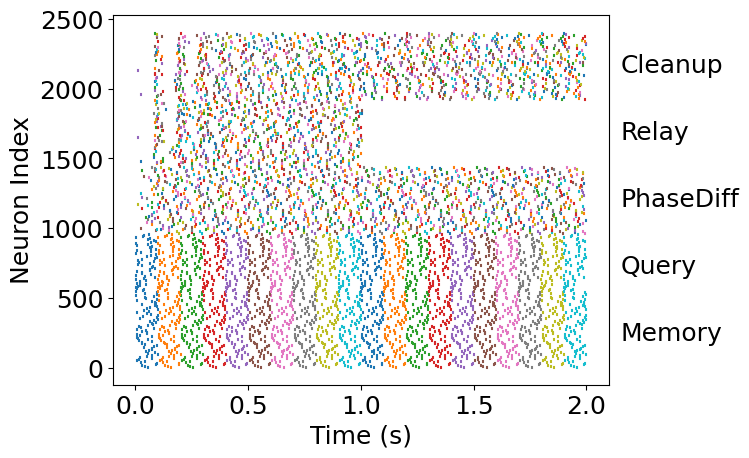

In [19]:
net.spike_raster()
plt.text(2.15, 200, 'Memory');
plt.text(2.15, 200+1*480, 'Query');
plt.text(2.15, 200+2*480, 'PhaseDiff');
plt.text(2.15, 200+3*480, 'Relay');
plt.text(2.15, 200+4*480, 'Cleanup');

('red', 0.060307388002528065)
('blue', -0.008247347374620637)
('green', 0.012801687152251402)
('square', 0.04192513668272501)
('circle', -0.03837040563329487)
('triangle', 0.018631049332460427)
('red square', 0.9934853863859159)
('red circle', 0.03157549466541823)
('red triangle', -0.030807630818897952)
('blue square', 0.023143367567001992)
('blue circle', 0.009970761192793541)
('blue triangle', -0.01334199056118991)
('green square', 0.0251692563953109)
('green circle', 0.00724832719282914)
('green triangle', -0.012804311489742821)


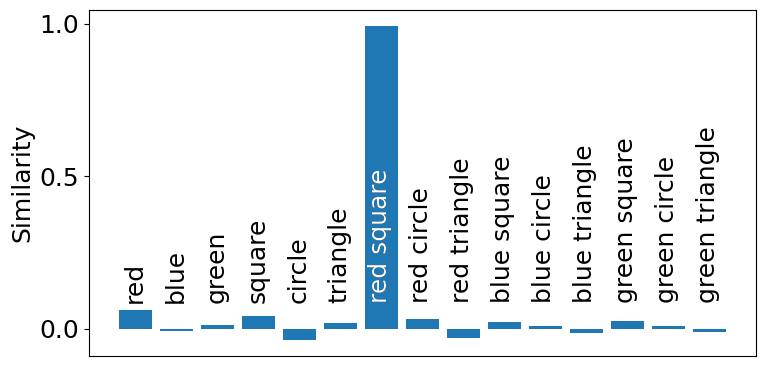

In [20]:
# What is at location x1?
max_k, sims = spiking_similarity(m3, V.all_vectors(), 1.9)
print(*list(zip(V.all_labels(),sims)), sep='\n')
V[max_k].label
idxs = range(len(sims))

figure(figsize=(8,4))
bar(idxs, sims);

fs = 18
nudge = 0.32
for k in range(len(V.stuff)):
    text(k-nudge, 0.1, V[k].label, fontsize=fs, rotation=90);
text(max_k-nudge, 0.1, V[max_k].label, color='white', fontsize=fs, rotation=90);
ylabel('Similarity'); yticks([0, 0.5, 1]);
xticks([]); tight_layout();
savefig('sim_barplot.pdf');

## Lava Lib

In [30]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import math, cmath

class hdv:
    dim=0
    def __init__(self, dim=0):
        self.dim = dim
        
    def get_rv(self):
        pass
    
    def bind(self, v1, v2):
        pass
    
    def bundle(self, arr_v):
        pass
    
    def similarity(self, v1, v2):
        pass
    
    def set_dim(self, dim):
        self.dim = dim
        
class FHRR(hdv):
    upper = math.pi
    lower = -math.pi
    def get_rv(self):
        angles = np.random.uniform(self.lower, self.upper, self.dim)
        elems = [ cmath.exp(1j*theta) for theta in angles ]
        return np.array(elems)
    
    def bind(self, v1, v2):
        angles_v1 = [cmath.polar(c)[1] for c in v1]
        angles_v2 = [cmath.polar(c)[1] for c in v2]
        sum_rslt =  [ cmath.exp((a1 + a2) * 1j) for a1, a2 in zip(angles_v1, angles_v2) ]
        return np.array(sum_rslt)
    
    def unbind(self, v1, v2):
        angles_v1 = [cmath.polar(c)[1] for c in v1]
        angles_v2 = [cmath.polar(c)[1] for c in v2]
        sum_rslt =  [ cmath.exp((a1 - a2) * 1j) for a1, a2 in zip(angles_v1, angles_v2) ]
        return np.array(sum_rslt)
    
    # def bundle(self, arr_v):
    #     rslt = np.zeros(self.dim)
    #     for v in arr_v:
    #         rslt = np.add(rslt, v)
        
    #     rslt_int = [ cmath.exp((cmath.polar(c)[1])*1j) for c in rslt]
        
    #     return np.array(rslt_int)
    def bundle(self, arr_v):
        result = np.zeros_like(arr_v[0])
        for vector in arr_v:
            # Add the current vector to the result vector
            result += vector
            # Normalize the result vector
            result = result / np.linalg.norm(result)

        return np.array(result)
    
    def similarity(self, v1, v2):
        angles_v1 = [cmath.polar(c)[1] for c in v1]
        angles_v2 = [cmath.polar(c)[1] for c in v2]
        
        sum_angles = 0
        for i in range(self.dim):
            sum_angles += (cmath.cos(angles_v1[i].real - angles_v2[i].real)).real
            
        return sum_angles / self.dim

#%%

In [23]:
F.shape[0]

480

In [24]:
v_th, sim_time = 100, 800

lib.set_params_manual(v_th, sim_time)
dim = F.shape[0]

encoder_F  = lib.FHRR_Encoder_Latency(vec = F)
encoder_P  = lib.FHRR_Encoder_Latency(vec = q)

unbind_snn = lib.FHRR_Multiply_Reverse(dimension=dim)

decoder    = lib.FHRR_Decoder(dimension=dim)

encoder_F.spikes_out.connect(unbind_snn.spikes_a_in)
encoder_P.spikes_out.connect(unbind_snn.spikes_b_in)
unbind_snn.spikes_out.connect(decoder.spikes_a_in)


In [25]:
decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())

In [26]:
import math

raw_rslt  = decoder.get_decoded_value()

raw_rslt_convert =  (v_th * 2*math.pi) / (sim_time * raw_rslt)

In [27]:
decoder.stop()

In [41]:
# Create an instance of the FHRR class
fhrr = FHRR(dim=F.shape[0])

# Convert raw_rslt_convert to complex array
# complex_result = util.phase2complex_array(raw_rslt_convert)
complex_result = fhrr.unbind(F, q)

sims = []

for vec in V.all_vectors():    
    # Calculate similarity using FHRR class method
    similarity = fhrr.similarity(vec, complex_result)
    sims.append(similarity)
    print(similarity)

0.06913977670719973
0.018307917847062084
-0.010090364439001659
0.02005197836650793
0.04169818212578923
-0.033036498537899354
0.5310369266560296
0.010693176977685261
-0.0328995270513517
0.04001904637645903
0.05009691727637952
0.03579406615233331
0.044968335475826
-0.0001505316272354838
0.017942306440456475


In [42]:
# Create an instance of the FHRR class
fhrr = FHRR(dim=F.shape[0])

# Convert raw_rslt_convert to complex array
# complex_result = util.phase2complex_array(raw_rslt_convert)
complex_result = fhrr.unbind(F, q)

for vec in V.all_vectors():    
    # Calculate similarity using FHRR class method
    similarity = fhrr.similarity(vec, complex_result)
    print(similarity)

0.06913977670719973
0.018307917847062084
-0.010090364439001659
0.02005197836650793
0.04169818212578923
-0.033036498537899354
0.5310369266560296
0.010693176977685261
-0.0328995270513517
0.04001904637645903
0.05009691727637952
0.03579406615233331
0.044968335475826
-0.0001505316272354838
0.017942306440456475


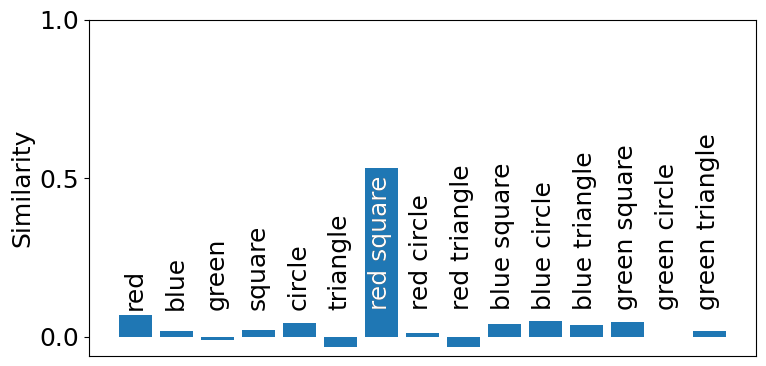

In [44]:
idxs = range(len(sims))

figure(figsize=(8,4))
bar(idxs, sims);

fs = 18
nudge = 0.32
for k in range(len(V.stuff)):
    text(k-nudge, 0.1, V[k].label, fontsize=fs, rotation=90);
text(max_k-nudge, 0.1, V[max_k].label, color='white', fontsize=fs, rotation=90);
ylabel('Similarity'); yticks([0, 0.5, 1]);
xticks([]); tight_layout();

### Net-2: objects query

In [42]:
# Net-2
# Create a spiking phasor network
net = SpikingPhasorNet()

# Spiking phasor population that outputs the spatial memory
Fpop = GenerateSP(N=N, C=F, freq=freq); net.add_pop(Fpop)

# Query vector is the bundle
q = V[10].v + V[14].v # "Blue Circle and Green Triangle"
q /= abs(q)

# Spiking phasor population that outputs the query
Q1 = GenerateSP(N=N, C=q, freq=freq); net.add_pop(Q1)

# Phase difference population (computes unbinding)
Z1 = PhaseDiffPop(N=N, freq=freq); net.add_pop(Z1)
net.deconvolve(Fpop, Q1, Z1)

In [43]:
net.total_neurons()

1440

In [44]:
start = time.time()
net.run(1.5*second)
duration = time.time() - start
print(f'Time: {duration}')

_cython_magic_bae8b6de304784adeadcfbf64344b990.cpp
c:\Users\21361535\AppData\Local\anaconda3\envs\beetroot-ml\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
   Creating library C:\Users\21361535\.cython\brian_extensions\Users\21361535\.cython\brian_extensions\_cython_magic_bae8b6de304784adeadcfbf64344b990.cp310-win_amd64.lib and object C:\Users\21361535\.cython\brian_extensions\Users\21361535\.cython\brian_extensions\_cython_magic_bae8b6de304784adeadcfbf64344b990.cp310-win_amd64.exp
Generating code
Finished generating code
_cython_magic_e917bb8d89ab16af46df803015ecd54f.cpp
c:\Users\21361535\AppData\Local\anaconda3\envs\beetroot-ml\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
   Creating library C:\Users\21361535\.cython\

cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warning D9025 : overriding '/W3' with '/w'
cl : Command line warnin

KeyboardInterrupt: 

In [ ]:
# Convert spiking phasor activity to complex vector (unit-modulus)
v = Z1.spikes2complex(1.4)

n_samples = 201
radius = 2
xvals = linspace(-radius, radius, n_samples)
yvals = linspace(-radius, radius, n_samples)

# Create spatial similarity map for the resulting hypervector
heatmap = complex_similarity_2D(v, ssp.S, yvals/yscale, xvals/xscale)

In [ ]:
k = argmax(ravel(heatmap))
maxc, maxr = unravel_index(k, heatmap.shape)

Max of 0.36723334645761235 at (34, 184); true (-1.3, -1.1)


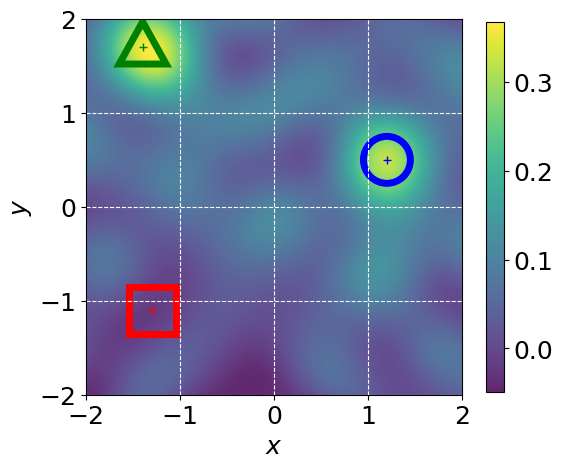

In [ ]:
# Display the similarity map, and the objects in the memory.
figure(figsize=(3*radius, 3*radius))
imshow(heatmap.T, extent=(-radius, radius,-radius, radius), origin='lower', alpha=0.85)#, cmap='hot');
colorbar(shrink=0.7);
grid('on', ls='--', color='w'); xlabel(r'$x$'); ylabel(r'$y$');
draw_shapes(); tight_layout();
xticks(arange(-radius, radius+1.e-5, 1))
yticks(arange(-radius, radius+1.e-5, 1))
savefig('object_locations.pdf')
print(f'Max of {heatmap[maxc,maxr]} at ({maxc}, {maxr}); true ({rsx[0]}, {rsx[1]})');